# Code Appendix: River Arun Bank Height Analysis

#### Imports and Function Definitions

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import scipy

In [363]:
data = pd.read_csv("1mtransect_clipped_1mres.csv")

In [364]:
# river height, from DEM
river_height = 0.0640

# flood height estimates, from simulation
flood_left = 2.75
flood_right = 2.90

In [365]:
def extractBanks(line, river_height = river_height):
    values = line['FIRST_Z']

    # determine where the first value equal to the river height is located
    start = values[values - river_height < 0.00001].index[0] - values.index[0]
    max_index = values.index[-1] - values.index[0]

    #first bank
    if start < max_index:
        a = values.iat[start]
        b = a
        k = start
        # iteratively compare points to determine where the bank crests
        while(a <= b and k < (max_index - 1)):
            a = b
            b = values.iat[k]
            k += 1
        right = a

    #second bank
    if start > 0:
        a = values.iat[start]
        b = values.iat[start - 1]
        k = start
        while(a <= b and k > 0):
            k -= 1
            a = b
            b = values.iat[k]
        left = a
    
    return(left,right)

In [366]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh
    # from https://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data

### Data Processing
In this section, raw data on transect elevation profiles is used to derive left and bank heights.  Outliers are determined perusant to Iglewicz and Hoaglin (1993).

In [367]:
left = []
right = []
# iterate through all lines entirely within the study area
for i in range(28, 1104):
    line = data.loc[data['LINE_ID'] == i]
    # ensure that the line isn't empty
    if len(line) != 0:
        l, r = extractBanks(line, river_height = river_height)
        left.append(l)
        right.append(r)

In [368]:
# create a version without outliers, with specific threshold
thresh = 3.5

# left bank
outlier_l = is_outlier(np.asarray(left), thresh = thresh)
left_no = []
left_no_index = []
for i in range(0,len(outlier_l)):
    if outlier_l[i] == False:
        left_no.append(left[i])
        left_no_index.append(i)
        
# right bank
outlier_r = is_outlier(np.asarray(right), thresh = thresh)
right_no = []
right_no_index = []
for i in range(0,len(outlier_r)):
    if outlier_r[i] == False:
        right_no.append(right[i])
        right_no_index.append(i)

### Transect Examination
To confirm that the method used was appropriate, we plot the elevation profile of one transect and the calculated left and right bank locations.

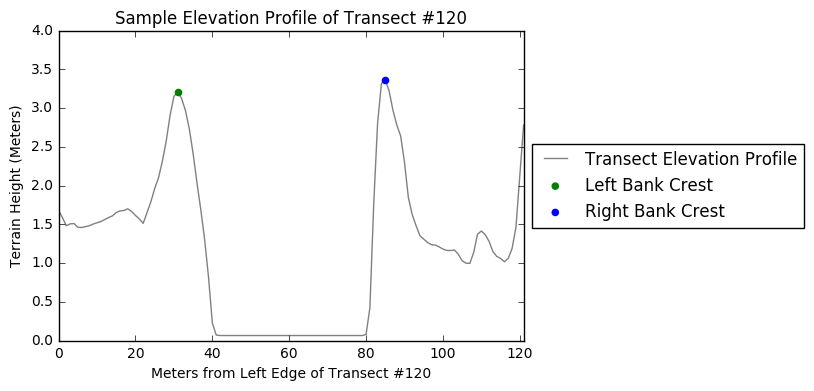

In [369]:
# extraction of a single transect to confirm methodology
line_numb = 120
line = data.loc[data['LINE_ID'] == line_numb]
values = line['FIRST_Z']

# find locations, height of left and right banks
l, r = extractBanks(line)
li = values[values == l].index[0]
ri = values[values == r].index[0]

plt.plot(values, label = "Transect Elevation Profile", zorder = 1, color = "grey")
plt.scatter(x = li, y = l, label = "Left Bank Crest", color = "green", zorder = 2)
plt.scatter(x = ri, y = r, color = "blue", label = "Right Bank Crest", zorder = 2)

x = np.arange(values.index[0],values.index[-1],20)
xtics = np.arange(0,121,20)
plt.xticks(x,xtics)

plt.ylim([0,4])
plt.xlim([values.index[0], values.index[-1]])
plt.ylabel("Terrain Height (Meters)")
plt.xlabel("Meters from Left Edge of Transect #%i" %line_numb)
plt.title("Sample Elevation Profile of Transect #%i" %line_numb)
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), scatterpoints = 1)
plt.show()

### Visualising Raw Estimated Bank Height for River Arun
These charts allow us to see the bank height estimated using this method along the length of River Arun.

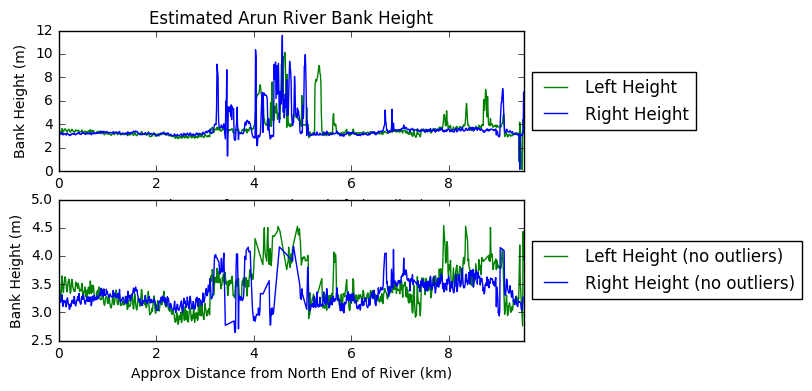

In [370]:
# adjust scales to kilometers
x = np.arange(0, 10001, 200)
xtics = np.arange(0, 11, 2)

plt.subplot(2,1,1)
plt.xticks(x,xtics)
plt.plot(left, label = "Left Height", color = "green")
plt.plot(right, label = "Right Height", color = "blue")
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Distance from North End of River (km)")
plt.ylabel("Bank Height (m)")
plt.title("Estimated Arun River Bank Height")

plt.subplot(2,1,2)
plt.xticks(x,xtics)
# plot without outliers
plt.plot(left_no_index, left_no, label = "Left Height (no outliers)", color = "green")
plt.plot(right_no_index, right_no, label = "Right Height (no outliers)", color = "blue")
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Approx Distance from North End of River (km)")
plt.ylabel("Bank Height (m)")
plt.show()

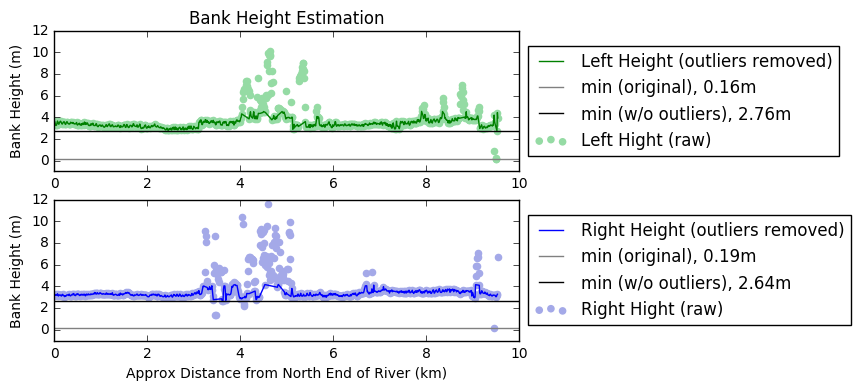

In [373]:
# plot outliers overlaid with minimums
x = np.arange(0, 10001, 200)
xtics = np.arange(0, 11, 2)
xindex = np.arange(0,len(left),1)

# left bank
plt.subplot(2,1,1)
plt.scatter(x = xindex, y = left, color = "#95dba4", label = "Left Hight (raw)")
plt.plot(left_no_index, left_no, label = "Left Height (outliers removed)", color = "green")
plt.axhline(np.min(left), label = "min (original), %1.2fm" %np.min(left), color = "gray")
plt.axhline(np.min(left_no), label = "min (w/o outliers), %1.2fm" %np.min(left_no), color = "k")

plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Bank Height (m)")
plt.title("Bank Height Estimation")
plt.xticks(x,xtics)
plt.xlim([0, 1000])
plt.ylim([-1, 12])

# right bank
plt.subplot(2,1,2)
plt.scatter(x = xindex, y = right, color = "#a4a9e8", label = "Right Hight (raw)")
plt.plot(right_no_index, right_no, label = "Right Height (outliers removed)", color = "blue")
plt.axhline(np.min(right), label = "min (original), %1.2fm" %np.min(right), color = "gray")
plt.axhline(np.min(right_no), label = "min (w/o outliers), %1.2fm" %np.min(right_no), color = "k")

plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Bank Height (m)")
plt.xlabel("Approx Distance from North End of River (km)")
plt.xticks(x,xtics)
plt.xlim([0, 1000])
plt.ylim([-1, 12])
plt.show()

### Comparison of Results
How close were the estimates of flood height we derived from bank height using Python to the estimates obtained fro simulating flooding in ArcPy?

In [375]:
# estimates for flooding
# left bank:
lflood = np.min(left) - river_height
lflood_no = np.min(left_no) - river_height
ldiff = np.abs(flood_left-lflood_no)
print("=== Left bank ===")
print("Estimated raw flood height: %1.2fm" %lflood)
print("Estimated flood height (outliers removed): %1.2fm" %lflood_no)
print("Simulated flood height: %1.2fm" %flood_left)
print("Difference between estimations: %1.2fm, %2.1f%%" %(ldiff, 100*np.divide(ldiff,lflood_no)))


# right bank
rflood = np.min(right) - river_height
rflood_no = np.min(right_no) - river_height
rdiff = np.abs(flood_right-rflood_no)
print("\n=== Right bank ===")
print("Estimated raw flood height: %1.2fm" %rflood)
print("Estimated flood height (outliers removed): %1.2fm" %rflood_no)
print("Simulated flood height: %1.2fm" %flood_right)
print("Difference between estimations: %1.2fm, %2.1f%%" %(rdiff, 100*np.divide(rdiff,rflood_no)))

=== Left bank ===
Estimated raw flood height: 0.10m
Estimated flood height (outliers removed): 2.69m
Simulated flood height: 2.75m
Difference between estimations: 0.06m, 2.1%

=== Right bank ===
Estimated raw flood height: 0.12m
Estimated flood height (outliers removed): 2.58m
Simulated flood height: 2.90m
Difference between estimations: 0.32m, 12.5%


In [377]:
print(np.min(left))
print(np.max(left))
print(np.median(left))

print(np.min(right))
print(np.max(right))
print(np.median(right))

0.164399999994
10.1353
3.37760000001
0.1875
11.584
3.3094
